## Importing 

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

## Obtaining the Raw data and the Target data created by  radar

In [8]:
raw_data = np.load("radar.npy")
target_data = np.load("target.npy")

## Variables 

In [9]:
number_of_antennas = 2  # Patch and Yagi
num_targets = 2  # Number of strongest targets to be chosen for target data

## Below STDFT (Short Time Discrete Fourier Transform) is calculated using numpy
### The formula of STDFT is 
## $$\overline{F}_j(k)=\sum^{N-1}_{n=0}{\overline{f}_j(n)e^{\frac{-i2\pi kn}{N} }}$$
## Where $f_j$ is j-th batch of the input 

## Calculating target data from  raw data and plotting it with the target data created by radar

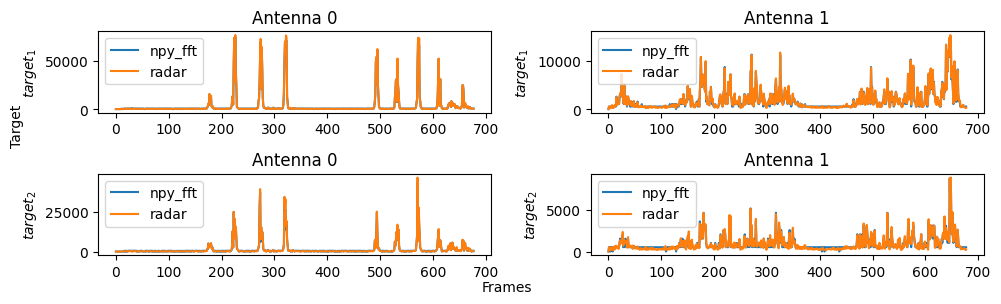

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(10, 3))

for i in range(number_of_antennas):

    # Obtaining antenna one by one for each for-loop
    antenna = raw_data[:, i, ...]

    # Obtaining in-phase component for the chosen antenna
    I_component = antenna[:, 0, :]

    # Obtaining quadrature component for the chosen antenna
    Q_component = antenna[:, 1, :]

    # Combining in-phase  and quadrature to get the whole data as a complex number
    data = np.vectorize(complex)(I_component, Q_component)

    # Removing mean
    data -= data.mean(axis=-1, keepdims=True)

    # Applying Short Time Fast Fourier Transform
    fft_data = np.fft.fft(data, axis=-1)

    # Applying Fourier Transform shift
    fft_data = np.fft.fftshift(fft_data, axes=-1)

    # Obtaining amplitudes of the frequencies
    amp = np.abs(fft_data)

    # Getting num_targets strongest targets from the data after FFT
    bins = np.argpartition(amp, -num_targets, axis=-1)[..., -num_targets:][..., ::-1]
    values = np.take_along_axis(amp, indices=bins, axis=-1)

    antenna_target = target_data[:, i, :]

    for j in range(num_targets):
        # Scaling values for plotting
        value_min_max = (values[:, j] - values[:, j].min()) / (
            values[:, j].max() - values[:, j].min()
        )

        # Bitshifts are used for cleaning the target data
        # because of the radar, which stores the information in 24 bits, the amplitdue
        # and the bin of the targets alongside, when converting them into npy files, the lower byte of
        # the amplitude are mixed up with the bin.
        #
        # redundant byte
        #        00000000|00000000|00000000|00000000|
        #                     amplitude       bin
        amp_target = ((0x00FF & antenna_target[:, 2 * j + 1].astype("int")) << 9) + (
            (0xFF00 & antenna_target[:, 2 * j].astype("int")) >> 8
        )

        # Scaling values for plotting
        amp_min_max = (amp_target - amp_target.min()) / (
            amp_target.max() - amp_target.min()
        )

        # Plotting newly calculated target
        ax[j, i].plot(amp_target, label="npy_fft")
        ax[j, i].set_title(f"Antenna {i}")

        # Ploting the target from radar
        ax[j, i].plot(values[:, j], label="radar")
        ax[j, i].set_ylabel(f"$target_{j+1}$")

        ax[j, i].legend(loc="upper left")

fig.text(0.5, 0.01, "Frames", ha="center")
fig.text(0.01, 0.5, "Target", ha="center", rotation="vertical")
plt.tight_layout()
plt.show()